<a href="https://colab.research.google.com/github/ruochee723/SC3000-Balancing-Pole-on-Cart/blob/main/src/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contributions

| Name | Matric Number |
|:---:|:---:|
|Pu Fanyi | U2220175K |
|Soo Ying Xi | U2220021D | 
|Ting Ruo Chee| |

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

# gymlogger.set_level(40)  # error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import math
import glob
import io
import base64
import torch

from typing import Tuple

random.seed(42)
gymlogger.set_level(10)  # debug

## Task 1: Development of an RL agent

First, we create an instance of the CartPole environment and define the ranges of the cart position and pole angle.

In [2]:
env = gym.make("CartPole-v1")

In [3]:
POSITION_RANGE = 4.8
ANGLE_RANGE = 0.418

NUM_BINS = {
    "position": 30,
    "velocity": 30,
    "pole_angle": 30,
    "pole_velocity": 30,
}

The observation space has $4$ values, and each value has a range of continuous numerical data. So, we define a function called `discretize` (...) to turn each value into a discrete value, which is an integer between $0$ to $29$ (inclusive).

We also note that the cart velocity and pole angle velocity have infinite range. So, we use a sigmoid function, $\sigma(x)=\frac{1}{1+e^{-x}}$, to trap the range of values between $0$ and $1$.

Finally, we combine the $4$ discretized values to compute the hashed state of the cartpole, which is a single integer.

In [4]:
def discretize(x: float, min_val: float, max_val: float, num_bins: int) -> int:
    if x > max_val:
        return num_bins - 1
    elif x < min_val:
        return 0
    else:
        return round((x - min_val) / (max_val - min_val) * (num_bins - 1))

In [5]:
from scipy.special import expit as sigmoid
from typing import Dict


def get_num_states():
    num_states = 1
    for num_bins in NUM_BINS.values():
        num_states *= num_bins
    return num_states


NUM_STATES = get_num_states()


class Observation(object):
    def __init__(self, observation):
        if isinstance(observation, tuple):
            observation = observation[0]
        self.observation = observation

    def position(self):
        return self.observation[0]

    def velocity(self):
        return self.observation[1]

    def pole_angle(self):
        return self.observation[2]

    def pole_velocity(self):
        return self.observation[3]

    def get_hashed_state_dict(self) -> Dict[str, int]:
        return {
            "position": discretize(
                self.position(), -POSITION_RANGE, POSITION_RANGE, NUM_BINS["position"]
            ),
            "velocity": discretize(
                sigmoid(self.velocity()),
                0,
                1,
                NUM_BINS["velocity"],
            ),
            "pole_angle": discretize(
                self.pole_angle(), -ANGLE_RANGE, ANGLE_RANGE, NUM_BINS["pole_angle"]
            ),
            "pole_velocity": discretize(
                sigmoid(self.pole_velocity()),
                0,
                1,
                NUM_BINS["pole_velocity"],
            ),
        }

    def get_hashed_state(self) -> int:
        hashed_state_tuple = self.get_hashed_state_dict()
        mul = 1
        hashed_state = 0
        for key, val in hashed_state_tuple.items():
            hashed_state += val * mul
            mul *= NUM_BINS[key]
        assert 0 <= hashed_state < NUM_STATES
        return hashed_state

    def get_vector(self) -> torch.Tensor:
        return torch.tensor(self.observation, dtype=torch.float32).unsqueeze(0)


def get_hashed_state(observation: np.ndarray) -> int:
    return Observation(observation).get_hashed_state()

### Abstract Class for RL Agent

We define an abstract class `Agent` and an inheritant class `Trainable_Agent`, which is then implemented by different (QLearning/ DQN) agents

In [6]:
from abc import ABC, abstractmethod


class Agent(ABC):
    def __init__(self, name: str):
        self.name = name

    @abstractmethod
    def _get_action(self, observation: Observation) -> int:
        raise NotImplementedError

    def get_action(self, observation: np.ndarray) -> int:
        return self._get_action(Observation(observation))

    def __call__(self, observation: np.ndarray) -> int:
        return self.get_action(observation)

The abstract class `TrainableAgent` has abstract method such as `train_episode(...)`, `save(...)`, `load(...)`

In [7]:
from tqdm import trange


class TrainableAgent(Agent, ABC):
    def __init__(self, name: str):
        self.episode_rewards = []
        super().__init__(name)

    def plot_rewards(self, smooth=100):
        index, rewards = map(np.array, zip(*self.episode_rewards))
        rewards = np.convolve(rewards, np.ones(smooth) / smooth, mode="valid")
        plt.plot(rewards)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title(f"Rewards for {self.name}")
        plt.show()

    def train(self, env: gym.Env, num_episodes: int, plot=False, plot_smooth=100):
        self.episode_rewards = []
        for t in trange(num_episodes, desc=f"Training {self.name}", unit="episode"):
            reward = self.train_episode(env)
            self.episode_rewards.append((t + 1, reward))
        if plot:
            self.plot_rewards(smooth=plot_smooth)

    @abstractmethod
    def train_episode(self, env: gym.Env) -> int:
        raise NotImplementedError

    @abstractmethod
    def save(self, path: str) -> None:
        raise NotImplementedError

    @abstractmethod
    def load(self, path: str) -> None:
        raise NotImplementedError

### Random Agent

In [8]:
class RandomAgent(Agent):
    def __init__(self):
        super().__init__("RandomAgent")

    def _get_action(self, observation: Observation) -> int:
        return random.randint(0, 1)

### Q Learning Agent

We introduce our `QLearningAgent` here

In [9]:
import os
import yaml
import datetime
from tqdm import trange
import pickle


class QLearningAgent(TrainableAgent):
    def __init__(
        self,
        *,
        file_path: str = None,
        state_space_size: int = NUM_STATES,
        action_space_size: int = 2,
        alpha: float = 0.1,
        gamma: float = 0.99,
        epsilon: float = 0.1,
    ):
        super().__init__("QLearningAgent")
        if file_path is not None:
            self.load(file_path)
        else:
            self.state_space_size = state_space_size
            self.action_space_size = action_space_size
            self.alpha = alpha
            self.gamma = gamma
            self.epsilon = epsilon
            self.q_table = np.zeros((state_space_size, action_space_size))
        self.time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    def reset(self):
        self.q_table = np.zeros((self.state_space_size, self.action_space_size))

    def _get_action(self, observation: Observation) -> int:
        return np.argmax(self.q_table[observation.get_hashed_state(), :])

    def train_episode(self, env: gym.Env):
        observation = env.reset()
        state = get_hashed_state(observation)
        done = False
        truncated = False
        sum_reward = 0
        while not done and not truncated and sum_reward < 500:
            if random.random() < self.epsilon:
                action = random.randint(0, 1)
            else:
                action = self.get_action(observation)
            next_observation, reward, done, truncated, info = env.step(action)
            next_state = get_hashed_state(next_observation)
            self.q_table[state, action] += self.alpha * (
                reward
                + self.gamma * np.max(self.q_table[next_state, :])
                - self.q_table[state, action]
            )
            sum_reward += reward
            state = next_state
            observation = next_observation
        return sum_reward

    def save(self, path: str = "models", model_name: str = None):
        os.makedirs(path, exist_ok=True)
        if model_name is None:
            name = f"{self.name}_{self.time}.pkl"
        elif model_name.endswith("pkl"):
            name = model_name
        else:
            name = f"{model_name}_{self.time}.pkl"
        path = os.path.join(path, name)
        path = os.path.abspath(path)
        with open(path, "wb") as f:
            data = {
                "time": self.time,
                "state_space_size": self.state_space_size,
                "action_space_size": self.action_space_size,
                "alpha": self.alpha,
                "gamma": self.gamma,
                "epsilon": self.epsilon,
                "q_table": self.q_table,
            }
            pickle.dump(data, f)
        gymlogger.info(f"Saved {self.name} to {path}")
        return path

    def load(self, path: str):
        with open(path, "rb") as f:
            data = pickle.load(f)
            self.time = data["time"]
            self.state_space_size = data["state_space_size"]
            self.action_space_size = data["action_space_size"]
            self.alpha = data["alpha"]
            self.gamma = data["gamma"]
            self.epsilon = data["epsilon"]
            self.q_table = data["q_table"]
        gymlogger.info(f"Loaded {self.name} from {path}")

We train the Q-Learning agent for 100 episodes. Then, we sample a random state from the environment and output the action chosen by the trained agent.

In [10]:
env.reset()
q_learning_agent = QLearningAgent()
q_learning_agent.train(env, num_episodes=100, plot=False)
observation = env.reset()
action = q_learning_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Training QLearningAgent:   0%|          | 0/100 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Training QLearningAgent: 100%|██████████| 100/100 [00:00<00:00, 657.17episode/s]

Observation: (array([ 0.0308496 , -0.00740319,  0.02502221,  0.03696973], dtype=float32), {})
Chosen action: 0


### Deep Q Learning Agent

We define the DeepQLearning Agent here. We used the `pytorch` library to implement the neural network.

We utilized some optimization techniques to improve the performance of the DQN agent. Main features as follows:
1. We used [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimizer with [Huber Loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) function to update the weights of the neural network.
2. We used [soft update](https://arxiv.org/pdf/1509.02971.pdf) to make the target network more stable.
3. We used [experience replay](https://arxiv.org/pdf/1312.5602.pdf) to efficiently use the data.

In [11]:
import os
import torch
import datetime
import pickle
from typing import Optional
from collections import deque, namedtuple


class QNetwork(torch.nn.Module):
    def __init__(
        self,
        state_space_dim: int,
        action_space_size: int,
        hidden_size=128,
        hidden_layers=2,
    ):
        super(QNetwork, self).__init__()
        self.layers = []
        self.layers.append(torch.nn.Linear(state_space_dim, hidden_size))
        for _ in range(hidden_layers - 1):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
        self.layers.append(torch.nn.Linear(hidden_size, action_space_size))
        self.layers = torch.nn.ModuleList(self.layers)

    def forward(self, state):
        for layer in self.layers[:-1]:
            state = torch.nn.functional.relu(layer(state))
        return self.layers[-1](state)


Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def save(self, path: str = "memory.pkl"):
        with open(path, "wb") as f:
            pickle.dump(self.memory, f)

    def load(self, path: str = "memory.pkl"):
        with open(path, "rb") as f:
            self.memory = pickle.load(f)


class DeepQLearningAgent(TrainableAgent):
    def __init__(
        self,
        state_space_dim=None,
        action_space_size=None,
        *,
        file_name: Optional[str] = None,
        batch_size=32,
        gamma=0.99,
        start_epsilon=0.9,
        end_epsilon=0.05,
        epsilon_decay=1000,
        tau=0.005,
        lr=1e-4,
        memory_capacity: int = 10000,
        enable_cuda: bool = True,
        hidden_size=128,
        hidden_layers=2,
        cuda_device_id=0,
    ):
        super().__init__("DeepQLearningAgent")
        self.time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        if file_name is not None:
            self.load(file_name)
        else:
            self.state_space_dim = state_space_dim
            self.action_space_size = action_space_size
            self.batch_size = batch_size
            self.hidden_size = hidden_size
            self.gamma = gamma
            self.start_epsilon = start_epsilon
            self.end_epsilon = end_epsilon
            self.epsilon_decay = epsilon_decay
            self.tau = tau
            self.lr = lr
            self.epsilon = start_epsilon
            self.hidden_layers = hidden_layers
            self.policy_net = QNetwork(
                state_space_dim,
                action_space_size,
                hidden_size=hidden_size,
                hidden_layers=hidden_layers,
            )
            self.target_net = QNetwork(
                state_space_dim,
                action_space_size,
                hidden_size=hidden_size,
                hidden_layers=hidden_layers,
            )
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.step_done = 0
        if enable_cuda:
            self.device = (
                f"cuda:{cuda_device_id}"
                if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_available() else "cpu"
            )
        else:
            self.device = "cpu"
        gymlogger.info(f"Using {self.device} device")
        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        self.optimizer = torch.optim.AdamW(
            self.policy_net.parameters(), lr=self.lr, amsgrad=True
        )
        self.memory = ReplayMemory(memory_capacity)

    def get_action_vec(self, observation: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return self.policy_net(observation).max(1).indices.view(1, 1)

    def _get_action(self, observation: Observation) -> int:
        return self.get_action_vec(observation.get_vector().to(self.device)).item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device,
            dtype=torch.bool,
        )

        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = (
                self.target_net(non_final_next_states).max(1).values
            )
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def train_episode(self, env: gym.Env) -> int:
        state, info = env.reset()
        state = (
            torch.tensor(state, dtype=torch.float32, device=self.device)
            .unsqueeze(0)
            .to(self.device)
        )
        sum_reward = 0
        while True:
            self.epsilon = self.end_epsilon + (
                self.start_epsilon - self.end_epsilon
            ) * math.exp(-1 * self.step_done / self.epsilon_decay)
            self.step_done += 1
            # print(self.epsilon)
            if random.random() < self.epsilon:
                action = torch.tensor(
                    [[env.action_space.sample()]],
                    device=self.device,
                    dtype=torch.long,
                )
            else:
                action = self.get_action_vec(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            sum_reward += reward
            reward = torch.tensor([reward], device=self.device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(
                    observation, dtype=torch.float32, device=self.device
                ).unsqueeze(0)

            # Store the transition in memory
            self.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            self.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = self.target_net.state_dict()
            policy_net_state_dict = self.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[
                    key
                ] * self.tau + target_net_state_dict[key] * (1 - self.tau)
            self.target_net.load_state_dict(target_net_state_dict)

            if done:
                break

        return sum_reward

    def save(self, folder, name: Optional[str]=None, **kwargs):
        os.makedirs(folder, exist_ok=True)
        if name is None:
            file_name = f"{self.name}_{self.time}.pth"
        elif name.endswith(".pth"):
            file_name = name
        else:
            file_name = f"{name}_{self.time}.pth"
        file_path = os.path.join(folder, file_name)
        file_path = os.path.abspath(file_path)
        data_to_save = {
            "policy_net_state_dict": self.policy_net.state_dict(),
            "target_net_state_dict": self.target_net.state_dict(),
            "config": {
                "state_space_dim": self.state_space_dim,
                "action_space_size": self.action_space_size,
                "hidden_size": self.hidden_size,
                "hidden_layers": self.hidden_layers,
                "tau": self.tau,
                "epsilon_decay": self.epsilon_decay,
                "start_epsilon": self.start_epsilon,
                "end_epsilon": self.end_epsilon,
                "lr": self.lr,
                "step_done": self.step_done,
                "batch_size": self.batch_size,
                "gamma": self.gamma,
            },
        }
        # Include any additional keyword arguments
        data_to_save["config"].update(kwargs)

        # Save to a single file
        torch.save(data_to_save, file_path)

        gymlogger.info(f"Saved {self.name} to {file_path}")

        return file_path

    def load(self, file_path):
        # Load data from file
        loaded_data = torch.load(file_path)

        # Restore configuration
        config = loaded_data["config"]
        self.tau = config["tau"]
        self.epsilon_decay = config["epsilon_decay"]
        self.start_epsilon = config["start_epsilon"]
        self.end_epsilon = config["end_epsilon"]
        self.state_space_dim = config["state_space_dim"]
        self.action_space_size = config["action_space_size"]
        self.hidden_size = config["hidden_size"]
        self.hidden_layers = config["hidden_layers"]
        self.lr = config["lr"]
        self.step_done = config["step_done"]
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]

        self.policy_net = QNetwork(
            self.state_space_dim,
            self.action_space_size,
            hidden_size=self.hidden_size,
            hidden_layers=self.hidden_layers,
        )

        self.target_net = QNetwork(
            self.state_space_dim,
            self.action_space_size,
            hidden_size=self.hidden_size,
            hidden_layers=self.hidden_layers,
        )

        # Restore model parameters for both policy_net and target_net
        self.policy_net.load_state_dict(loaded_data["policy_net_state_dict"])
        self.target_net.load_state_dict(loaded_data["target_net_state_dict"])

        gymlogger.info(f"Loaded {self.name} from {file_path}")

Now, we train the Deep Q-Learning agent for 100 episodes, sample a random state, and output the chosen action.

In [12]:
env.reset()
deep_q_learning_agent = DeepQLearningAgent(
    state_space_dim=4, action_space_size=2, batch_size=60
)
deep_q_learning_agent.train(env, num_episodes=100, plot=False)
observation = env.reset()
action = deep_q_learning_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

INFO: Using cuda:0 device
Training DeepQLearningAgent: 100%|██████████| 100/100 [00:03<00:00, 26.30episode/s]

Observation: (array([ 0.02813855,  0.02151275, -0.0046854 , -0.0494275 ], dtype=float32), {})
Chosen action: 1


### Eval Script

We also implement a evaluation function which serves to return the average and standard deviation of the rewards.

In [13]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


def play_episode(agent: Agent, env: gym.Env) -> float:
    observation = env.reset()
    done = False
    truncated = False
    reward = 0
    while not done and not truncated and reward < 500:
        action = agent(observation)
        next_observation, r, done, truncated, info = env.step(action)
        reward += r
        observation = next_observation
    reward = min(reward, 500)
    return reward


def play(agent: Agent, num_episodes: int = 1000, num_threads: int = 1):
    all_rewards = []

    progress_bar = tqdm(total=num_episodes, desc="Playing", unit="episode")

    def play_multiple_episodes(episodes: int, rank: int):
        env = gym.make("CartPole-v1")
        rewards = []
        for i in range(episodes):
            progress_bar.update(1)
            rewards.append(play_episode(agent, env))
        return rewards

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        threads_loads = [num_episodes // num_threads] * num_threads
        threads_loads[-1] += num_episodes % num_threads
        all_rewards = sum(
            executor.map(play_multiple_episodes, threads_loads, range(num_threads)), []
        )

    progress_bar.close()

    return np.array(all_rewards)


def eval(agent: Agent, num_episodes: int, threads: int) -> float:
    rewards = play(agent, num_episodes=num_episodes, num_threads=threads)
    return np.mean(rewards), np.std(rewards)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

---

### Q Learning Agent

First, we trained the `QLearningAgent` with predefined parameters.

Training QLearningAgent: 100%|██████████| 5000/5000 [00:24<00:00, 205.71episode/s]


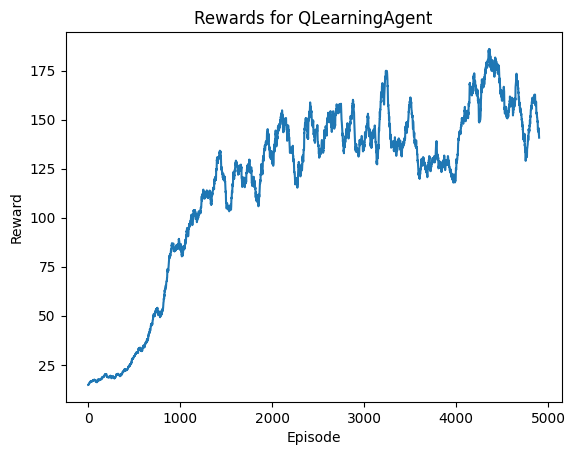

In [74]:
q_learning_agent = QLearningAgent(alpha=0.1, gamma=0.999, epsilon=0.3)
q_learning_agent.train(env, 5000, plot=True)

In [75]:
q_learning_agent.save("models", "QL_base")

INFO: Saved QLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/QL_base_2024-04-04_16-28-20.pkl


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/QL_base_2024-04-04_16-28-20.pkl'

In [76]:
mean, std = eval(q_learning_agent, 1000, 30)
print(f"Mean reward: {mean}, std: {std}")

Playing:   0%|          | 0/1000 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 1000/1000 [00:34<00:00, 29.36episode/s]


(342.034, 124.49127215993899)

We found that the model has nearly converged at this parameter setting. We fine-tune the agent by setting smaller $\alpha$ and $\epsilon$ values. We set the $\alpha$ and $\epsilon$ value be $0.01$, to balance the agent's exploration while enhancing the stability.

We load the model trained for fine-tuning.

In [96]:
q_learning_agent_finetuned = QLearningAgent(
    file_path="models/QL_base_2024-04-04_15-53-23.pkl"
)

INFO: Loaded QLearningAgent from models/QL_base_2024-04-04_15-53-23.pkl


Training QLearningAgent: 100%|██████████| 3000/3000 [00:42<00:00, 70.04episode/s] 


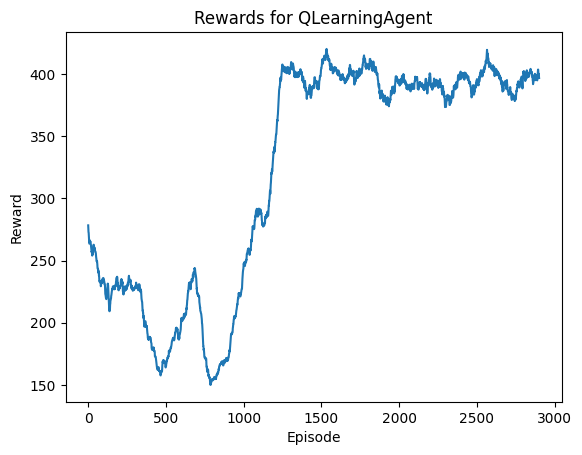

In [97]:
q_learning_agent_finetuned.alpha = 0.01
q_learning_agent_finetuned.epsilon = 0.01
q_learning_agent_finetuned.train(env, 3000, plot=True)

In [98]:
mean, std = eval(q_learning_agent_finetuned, 1000, 60)
print(f"Mean reward: {mean}, std: {std}")

Playing:   0%|          | 0/1000 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 1000/1000 [00:37<00:00, 26.94episode/s]


(382.666, 105.08295981746994)

In [66]:
q_learning_agent_finetuned.save("models", "QL_FT")

INFO: Saved QLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/QL_FT_2024-04-04_16-19-03.pkl


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/QL_FT_2024-04-04_16-19-03.pkl'

## Cumulative rewards for Q-Learning agent

The fine-tuned QLearning Agent is loaded and the graph of cumulated rewards after playing for 100 episodes is plotted.

INFO: Loaded QLearningAgent from models/QL_FT_2024-04-04_16-19-03.pkl
Playing:   0%|          | 0/100 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 100/100 [00:03<00:00, 25.31episode/s]


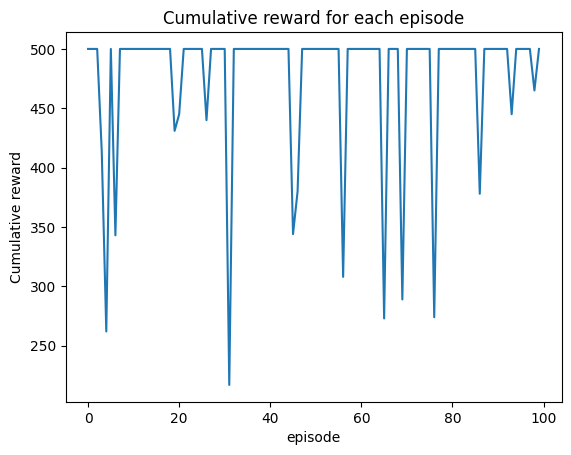

In [99]:
q_learning_agent = QLearningAgent(file_path="models/QL_FT_2024-04-04_16-19-03.pkl")
episode_results = play(q_learning_agent, num_episodes=100, num_threads=30)
plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

As the results shown in the graph, the average cumulative rewards was higher than $195$. However, considering the issue of complexity, Q learning struggles with environment with large and continuous state space. This motivated us to do more research and leverage the benefits of deep neural network. 

---

### Another(Advanced) Approach: Deep Q Learning

#### Rough Training

We firstly train 150 episodes for the Deep Q Learning Agent with different parameters to find the potential best agent, and we selected the top 3 agents for further training.

For all the codes below, we ran several times to find the best agent. (Actually we tried more parameters than below, but to make it not too long, we only showed 3 examples we tried which we selected for further training).

INFO: Using cuda:0 device
Training DeepQLearningAgent: 100%|██████████| 150/150 [00:47<00:00,  3.17episode/s]


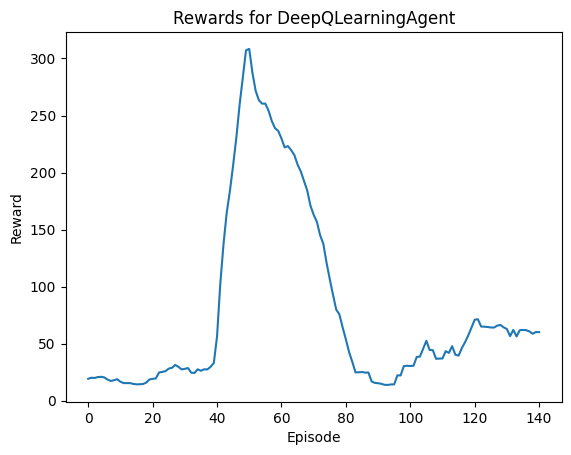

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_1_2024-04-05_22-02-31.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_1_2024-04-05_22-02-31.pth'

In [54]:
deep_q_learning_agent = DeepQLearningAgent(
    state_space_dim=4,
    action_space_size=2,
    enable_cuda=True,
    hidden_size=128,
    hidden_layers=5,
    batch_size=128,
)
deep_q_learning_agent.train(env, num_episodes=150, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_base_1")

INFO: Using cuda:0 device
Training DeepQLearningAgent: 100%|██████████| 150/150 [00:44<00:00,  3.39episode/s]


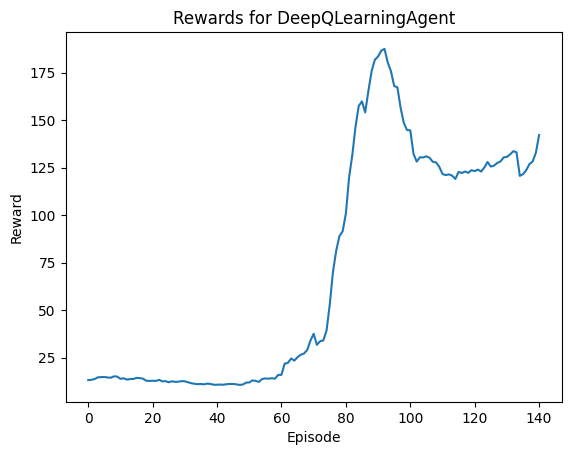

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_2_2024-04-05_22-01-37.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_2_2024-04-05_22-01-37.pth'

In [53]:
deep_q_learning_agent = DeepQLearningAgent(
    state_space_dim=4,
    action_space_size=2,
    enable_cuda=True,
    hidden_size=128,
    hidden_layers=5,
    batch_size=128,
    start_epsilon=0.5,
)
deep_q_learning_agent.train(env, num_episodes=150, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_base_2")

INFO: Using cuda:0 device
Training DeepQLearningAgent: 100%|██████████| 150/150 [00:41<00:00,  3.58episode/s]


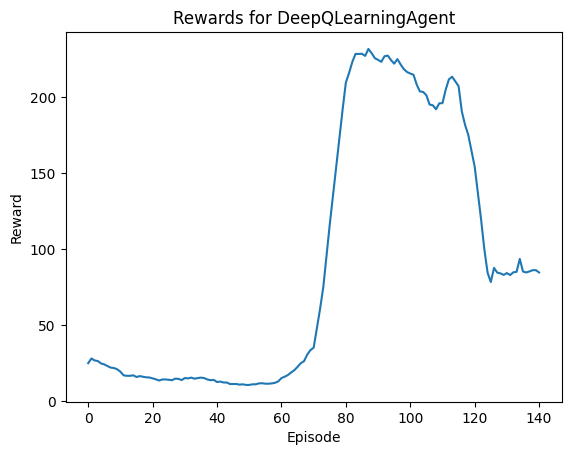

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_3_2024-04-05_22-03-26.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_base_3_2024-04-05_22-03-26.pth'

In [55]:
deep_q_learning_agent = DeepQLearningAgent(
    state_space_dim=4,
    action_space_size=2,
    enable_cuda=True,
    hidden_size=128,
    hidden_layers=3,
    batch_size=128,
)
deep_q_learning_agent.train(env, num_episodes=150, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_base_3")

We found that the model will have the decreasing trend of rewards after a certain number of episodes. A possible reason is that the model is overfitting. However, based on a [reasearch](https://arxiv.org/abs/1912.02292) done by [OpenAI](https://openai.com/research/deep-double-descent), there is a phenomenon called "Deep Double Descent" may explain this situation. The model may have a decreasing trend of rewards after a certain number of episodes, but it will increase again after a certain number of episodes.

![](imgs/DeepDoubleDescent.webp)

So we tried to train the model for more episodes to see if the rewards will increase again.

#### Further Training

We further train the top 3 agents for 500 episodes to see if the rewards will increase again.

INFO: Loaded DeepQLearningAgent from models/DQL_base_1_2024-04-05_22-02-31.pth
INFO: Using cuda:0 device
Training DeepQLearningAgent:   0%|          | 0/300 [00:00<?, ?episode/s]

Training DeepQLearningAgent: 100%|██████████| 300/300 [02:17<00:00,  2.19episode/s]


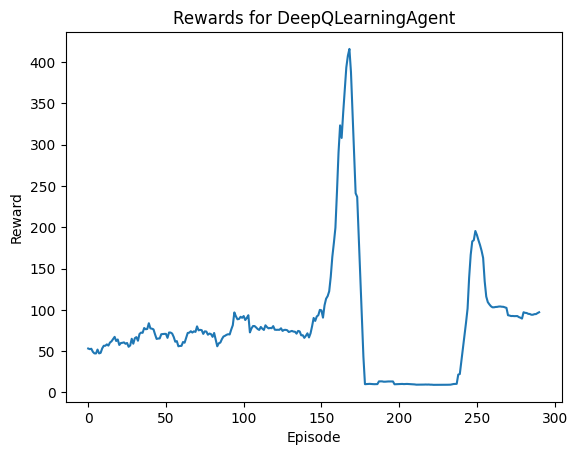

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_1_2024-04-05_22-12-08.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_1_2024-04-05_22-12-08.pth'

In [59]:
deep_q_learning_agent = DeepQLearningAgent(
    file_name="models/DQL_base_1_2024-04-05_22-02-31.pth",
)
deep_q_learning_agent.train(env, num_episodes=300, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_further_1")

INFO: Loaded DeepQLearningAgent from models/DQL_base_2_2024-04-05_22-01-37.pth
INFO: Using cuda:0 device
Training DeepQLearningAgent:   0%|          | 0/400 [00:00<?, ?episode/s]

Training DeepQLearningAgent: 100%|██████████| 400/400 [14:44<00:00,  2.21s/episode]


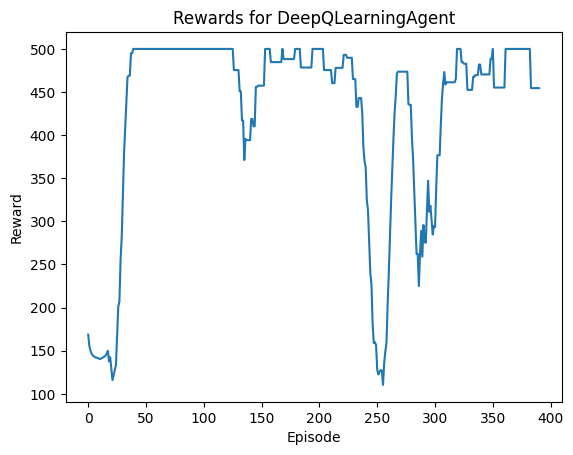

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_2_2024-04-05_22-42-51.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_2_2024-04-05_22-42-51.pth'

In [63]:
deep_q_learning_agent = DeepQLearningAgent(
    file_name="models/DQL_base_2_2024-04-05_22-01-37.pth",
)
deep_q_learning_agent.train(env, num_episodes=400, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_further_2")

INFO: Loaded DeepQLearningAgent from models/DQL_base_3_2024-04-05_22-03-26.pth
INFO: Using cuda:0 device
Training DeepQLearningAgent: 100%|██████████| 300/300 [01:36<00:00,  3.11episode/s]


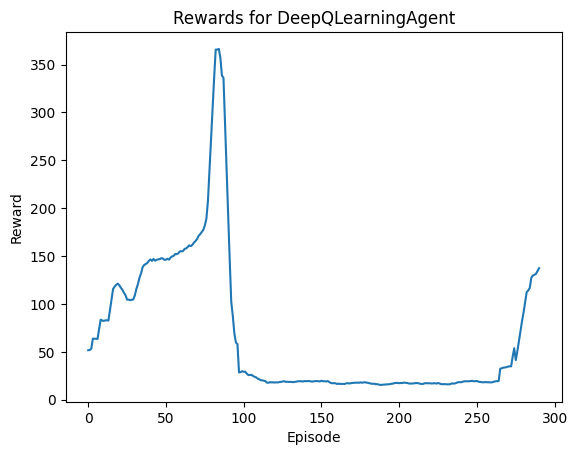

INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_3_2024-04-05_22-39-20.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_further_3_2024-04-05_22-39-20.pth'

In [62]:
deep_q_learning_agent = DeepQLearningAgent(
    file_name="models/DQL_base_3_2024-04-05_22-03-26.pth",
)
deep_q_learning_agent.train(env, num_episodes=300, plot=True, plot_smooth=10)
deep_q_learning_agent.save("models", "DQL_further_3")

We found that the score increased again after a certain number of episodes, especially for the second agent.

We tried to evaluate the agents to see which one is the best.

In [14]:
import pandas as pd

agent_1_file = "models/DQL_further_1_2024-04-05_22-12-08.pth"
agent_2_file = "models/DQL_further_2_2024-04-05_22-28-08.pth"
agent_3_file = "models/DQL_further_3_2024-04-05_22-39-20.pth"

agent_1_score, agent_1_std = eval(DeepQLearningAgent(file_name=agent_1_file), 100, 30)
agent_2_score, agent_2_std = eval(DeepQLearningAgent(file_name=agent_2_file), 100, 30)
agent_3_score, agent_3_std = eval(DeepQLearningAgent(file_name=agent_3_file), 100, 30)

scores = pd.DataFrame(
    {
        "Agent": ["1", "2", "3"],
        "Mean": [agent_1_score, agent_2_score, agent_3_score],
        "Std": [agent_1_std, agent_2_std, agent_3_std],
    }
)

INFO: Loaded DeepQLearningAgent from models/DQL_further_1_2024-04-05_22-12-08.pth
INFO: Using cuda:0 device
Playing:   0%|          | 0/100 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 100/100 [00:06<00:00, 16.51episode/s]
INFO: Loaded DeepQLearningAgent from models/DQL_further_2_2024-04-05_22-28-08.pth
INFO: Using cuda:0 device
Playing: 100%|██████████| 100/100 [00:31<00:00,  3.19episode/s]
INFO: Loaded DeepQLearningAgent from models/DQL_further_3_2024-04-05_22-39-20.pth
INFO: Using cuda:0 device
Playing: 100%|██████████| 100/100 [00:07<00:00, 13.02episode/s]


In [15]:
scores

,Agent,Mean,Std
0,1,104.85,5.706794
1,2,500.00,0.000000
2,3,143.50,6.562774


So we found that model 2 is the best one.

In [17]:
deep_q_learning_agent = DeepQLearningAgent(file_name=agent_2_file)
deep_q_learning_agent.save("models", "DQL_best")

INFO: Loaded DeepQLearningAgent from models/DQL_further_2_2024-04-05_22-28-08.pth
INFO: Using cuda:0 device
INFO: Saved DeepQLearningAgent to /data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_best_2024-04-05_23-05-46.pth


'/data/pufanyi/project/SC3000-Balancing-Pole-on-Cart/src/models/DQL_best_2024-04-05_23-05-46.pth'

### Cumulative rewards for Deep Q-Learning agent

Playing:   0%|          | 0/100 [00:00<?, ?episode/s]

/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 100/100 [01:24<00:00,  1.19episode/s]


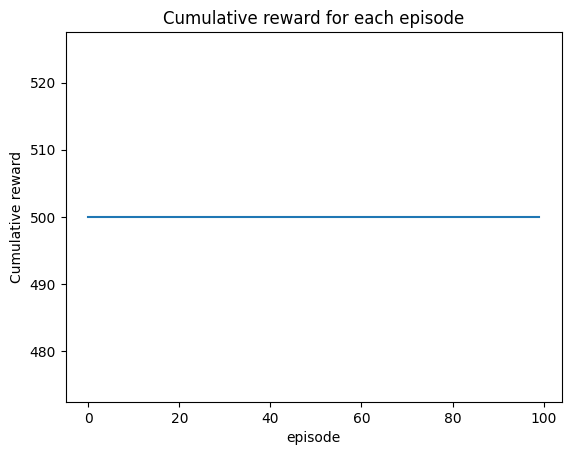

In [18]:
episode_results = play(deep_q_learning_agent, num_episodes=100, num_threads=30)
plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

Print the average reward over the 100 episodes.

In [19]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

We try to select the best agent (`DQL_best_2024-04-05_23-05-46`) and render one episode played by the agent.

In [22]:
import os
import imageio
import datetime
from PIL import Image
from IPython.display import Video


def get_video_path(
    agent: Agent, *, video_name: str = "default", video_folder: str = "video"
) -> str:
    os.makedirs(video_folder, exist_ok=True)
    if video_name == "default":
        video_name = f"{agent.name}_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
    if not video_name.endswith(".mp4"):
        video_name += ".mp4"
    return os.path.join(video_folder, video_name)


def render(
    agent: Agent,
    video_name: str = "default",
    fps: int = 20,
    width: int = 600,
    height: int = 400,
    video_folder: str = "video",
):
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    frames = []
    observation = env.reset()
    while True:
        frames.append(Image.fromarray(env.render()).resize((width, height)))
        action = agent(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    env.close()

    video_path = get_video_path(agent, video_name=video_name, video_folder=video_folder)
    imageio.mimsave(video_path, frames, fps=fps)

    return Video(video_path)

In [25]:
deep_q_learning_agent = DeepQLearningAgent(file_name="models/DQL_best_2024-04-05_23-05-46.pth")
render(deep_q_learning_agent)

INFO: Loaded DeepQLearningAgent from models/DQL_best_2024-04-05_23-05-46.pth
INFO: Using cuda:0 device
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6990c40] Warning: data is not aligned! This can lead to a speed loss


# References

1. Paszke, A., & Towers, M. (n.d.). Reinforcement Learning (DQN) Tutorial. PyTorch. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
<br>
2. Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., & Wierstra, D. (2016). Continuous Control With Deep Reinforcement Learning. ICLR 2016. https://arxiv.org/pdf/1509.02971.pdf